In [63]:
# 1. Download the datasets - Boston House pricing, Titanic survivors
# Do we do imputation? - No we skip for this excercise

# https://seaborn.pydata.org/tutorial/axis_grids.html

# 1. Are we doing classification  or regression trees?
#    Use Gini, Entropy gain, Information gain
#    Pruning

In [86]:
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations, product

import matplotlib.pyplot as plt 

from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate

from ucimlrepo import fetch_ucirepo 

# from utils import plot_decision_tree, plot_decision_surface, plot_feature_importance, plot_partial_dependence
from utils import get_df_details, plot_distrb

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [65]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
census_income = fetch_ucirepo(id=20) 
  
# data (as pandas dataframes) 
X = census_income.data.features 
y = census_income.data.targets 
  
# metadata 
print(census_income.metadata) 
  
# variable information 
print(census_income.variables) 


# Easy to understand data - => easier to sense check the result of the models
# Has a large data set
# Has mix of binary and integer data
# No missing data points
# The other dataset is coategorical dataset - has missing data
# Classification ouitcome is also binary

# Use phi coefficeint to find correlated data


{'uci_id': 20, 'name': 'Census Income', 'repository_url': 'https://archive.ics.uci.edu/dataset/20/census+income', 'data_url': 'https://archive.ics.uci.edu/static/public/20/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data.  Also known as Adult dataset.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5GP7S', 'creators': ['Ron Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && 

In [68]:
X_summary = get_df_details(X)
X_summary.merge(census_income.variables.set_index('name'), how='outer', left_index=True, right_index=True)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nunique,n_nulls,dtype,role,type,demographic,description,units,missing_values
age,48842.0,NaN,NaN,NaN,38.643585,13.71051,17.0,28.0,37.0,48.0,90.0,74.0,0.0,int64,Feature,Integer,Age,N/A,None,no
capital-gain,48842.0,NaN,NaN,NaN,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0,123.0,0.0,int64,Feature,Integer,None,None,None,no
capital-loss,48842.0,NaN,NaN,NaN,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0,99.0,0.0,int64,Feature,Integer,None,None,None,no
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,object,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
education-num,48842.0,NaN,NaN,NaN,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0,16.0,0.0,int64,Feature,Integer,Education Level,None,None,no
fnlwgt,48842.0,NaN,NaN,NaN,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0,28523.0,0.0,int64,Feature,Integer,None,None,None,no
hours-per-week,48842.0,NaN,NaN,NaN,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0,96.0,0.0,int64,Feature,Integer,None,None,None,no
income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Target,Binary,Income,">50K, <=50K.",None,no
marital-status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.0,object,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
native-country,48568,42,United-States,43832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,274.0,object,Feature,Categorical,Other,"United-States, Cambodia, England, Puerto-Rico,...",None,yes


In [69]:
idx = census_income['variables']['type'] == 'Integer'
int_cols = census_income['variables'].loc[idx, 'name']
int_cols = int_cols.loc[~int_cols.isin(y.columns.tolist())]

In [70]:
int_cols

0                age
2             fnlwgt
4      education-num
10      capital-gain
11      capital-loss
12    hours-per-week
Name: name, dtype: object

In [71]:
idx = census_income['variables']['type'] == 'Categorical'
cat_cols = census_income['variables'].loc[idx, 'name']

cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]


In [72]:
cat_cols

1          workclass
3          education
5     marital-status
6         occupation
7       relationship
8               race
13    native-country
Name: name, dtype: object

In [73]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

from sklearn.model_selection import StratifiedKFold, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# EDA - on the TRAIN data set
1. For the binary value to a % plot of distribution - note the ones that are very skewed
2. For the continuous data - do a violin plot distribution  - do we need normalisation here?
3. Do a correlation plot o

In [74]:

X_eda = X_train.copy()

In [75]:
X_melt = X_eda.melt(id_vars=['age', 'sex'], 
                var_name='metric')

In [76]:
X_melt.head()

,age,sex,metric,value
0,32,Male,workclass,Private
1,45,Male,workclass,State-gov
2,35,Male,workclass,Local-gov
3,64,Male,workclass,Private
4,63,Male,workclass,Self-emp-not-inc


In [88]:

def plot_distrb(df):
    """
    plot value counts for each column as subplots
    if the column is categorical, use countplot
    if the column is numerical, use distplot

    # https://www.statology.org/seaborn-subplots/

    Args:
        df (pd.DataFrame): DataFrame in wide formatr to plot
    """
    plot_rows = np.ceil(np.sqrt(df.shape[1])).astype(int)

    fig, ax = plt.subplots(plot_rows, plot_rows, figsize=(20, 20))

    axs = list(product(range(plot_rows), range(plot_rows)))
    
    for i in range(df.shape[1]):

        col = df.iloc[:, i]
        if col.dtype == 'object':
            sns.countplot(col, ax=ax[*axs[i]])
        else:
            sns.histplot(col, ax=ax[*axs[i]])
    

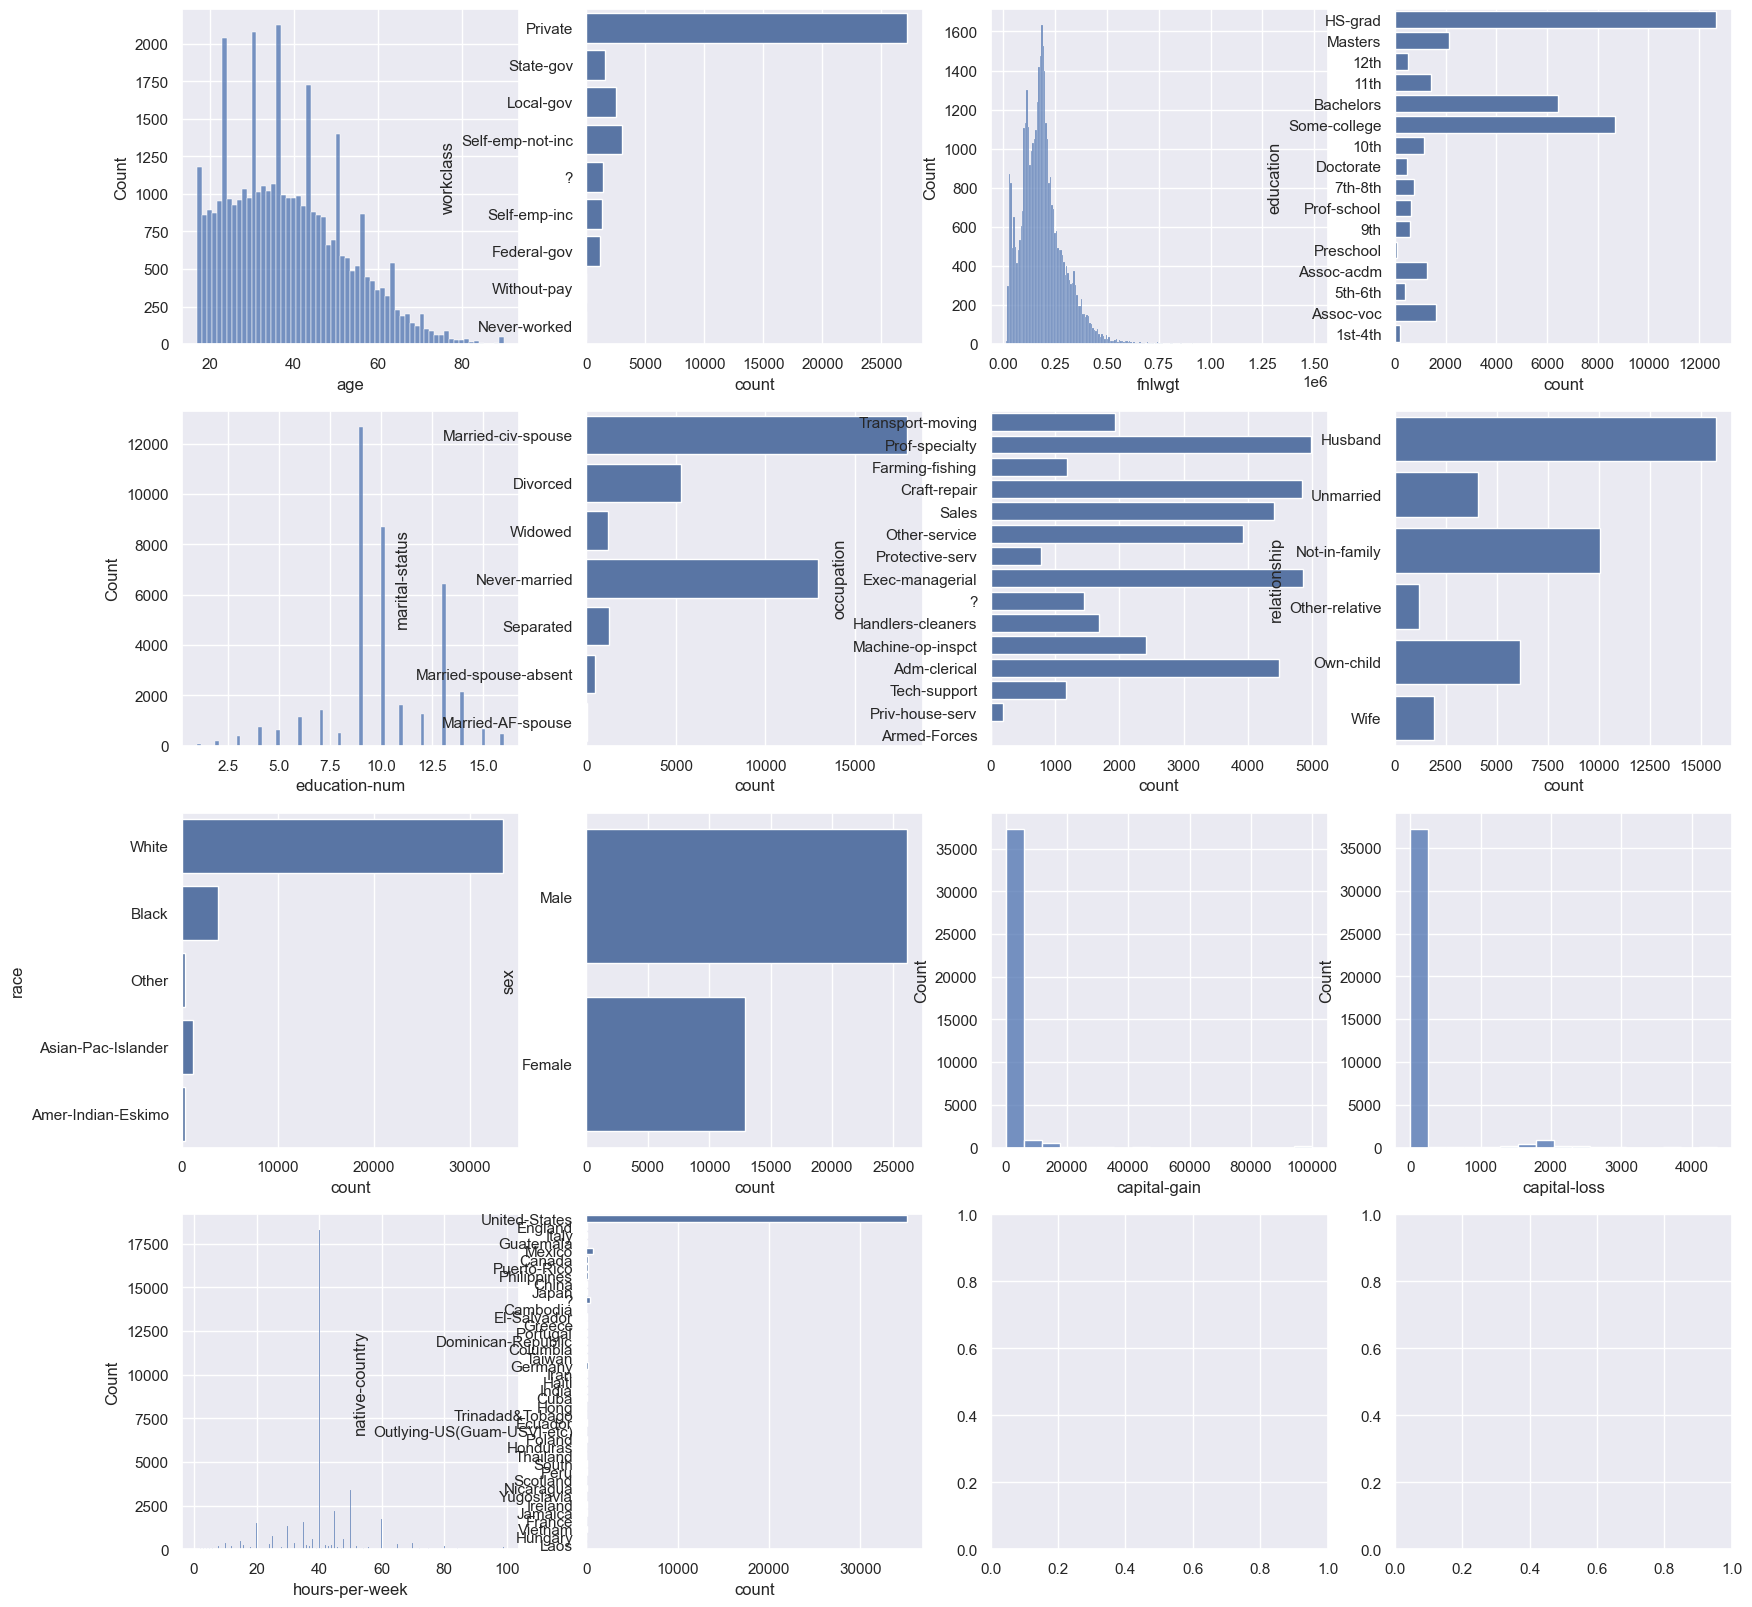

In [89]:
plot_distrb(X_eda)

<Axes: >

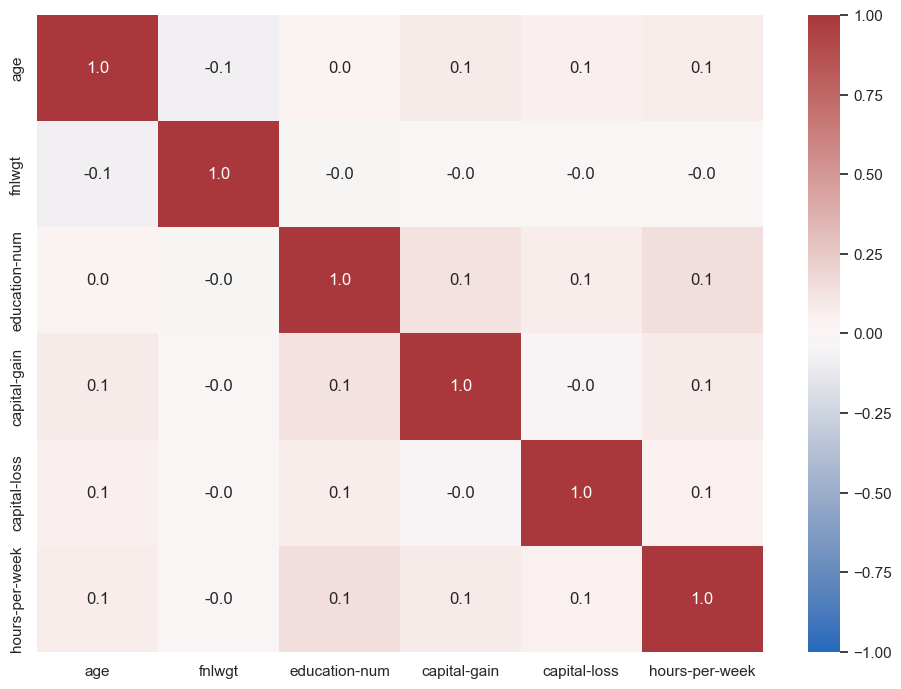

In [77]:
sns.heatmap(X_eda[int_cols].corr(),annot=True, fmt=".1f", vmin=-1, vmax = 1, cmap='vlag')

In [78]:

X_int_melt = X_melt.query('metric in @int_cols')

In [79]:
X_int_melt

,age,sex,metric,value
39073,32,Male,fnlwgt,50753
39074,45,Male,fnlwgt,144351
39075,35,Male,fnlwgt,252217
39076,64,Male,fnlwgt,69525
39077,63,Male,fnlwgt,28612
...,...,...,...,...
429798,35,Male,hours-per-week,50
429799,21,Female,hours-per-week,40
429800,23,Female,hours-per-week,40
429801,18,Female,hours-per-week,20


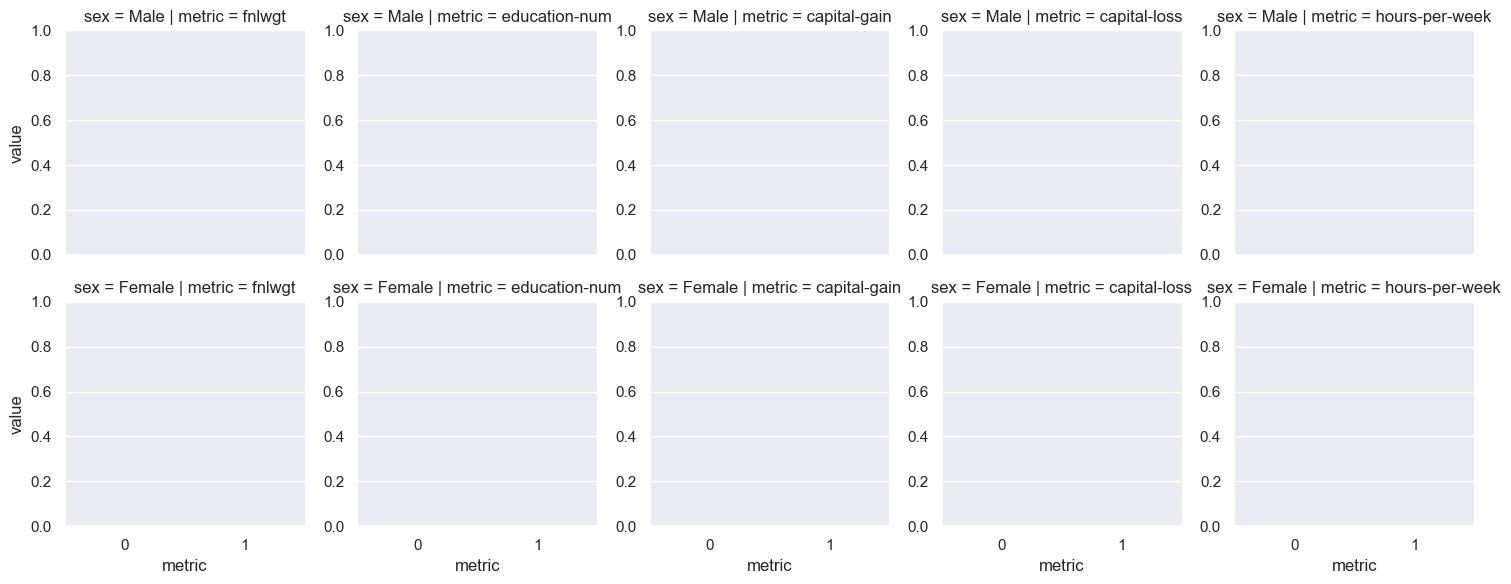

In [82]:

def _violinplot(x, y, hue,  **kwargs):
    """
    https://stackoverflow.com/a/44035405/6931113

    x: pd.series
    """
    sns.violinplot(x=x, y=y, hue=hue, **kwargs)

g = sns.FacetGrid(X_int_melt, row="sex", col='metric', sharey=False)
g.map(_violinplot, 'metric', 'value',  'sex', split=True, inner="quart", palette="Set3", order=[0, 1], legend=True)

In [16]:
cols = ['age', 'sex'] + cat_cols.tolist()
X_cat_melt = X_melt.query('metric in @cat_cols')

In [21]:
def _countplot(x, hue, palette='dark:#4c72b0', **kwargs):
    """
    https://stackoverflow.com/a/44035405/6931113

    x: pd.series
    """
    sns.countplot(x=x, hue=hue, palette=palette, **kwargs)

    
def plot_countplot(X_melt):
    """
        https://stackoverflow.com/a/69813924/6931113
    """
    g = sns.FacetGrid(X_melt, col="metric")
    g.map(_countplot, "value", "sex", order=[0, 1], stat='percent')
    g.set_xticklabels(['No', 'Yes'])
    g.set_titles("metric = {col_name}")
    g.set_axis_labels("", "Percentage")
    g.add_legend()
    # g.fig.subplots_adjust(wspace=.02)
    # g.fig.suptitle('Countplot of X_melt by metric')
    for ax in g.axes.flat:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    return ax


In [22]:
X_cat_melt


,age,sex,metric,value
0,32,Male,workclass,Private
1,45,Male,workclass,State-gov
2,35,Male,workclass,Local-gov
3,64,Male,workclass,Private
4,63,Male,workclass,Self-emp-not-inc
...,...,...,...,...
468871,35,Male,native-country,?
468872,21,Female,native-country,United-States
468873,23,Female,native-country,United-States
468874,18,Female,native-country,United-States


<Axes: title={'center': 'metric = native-country'}>

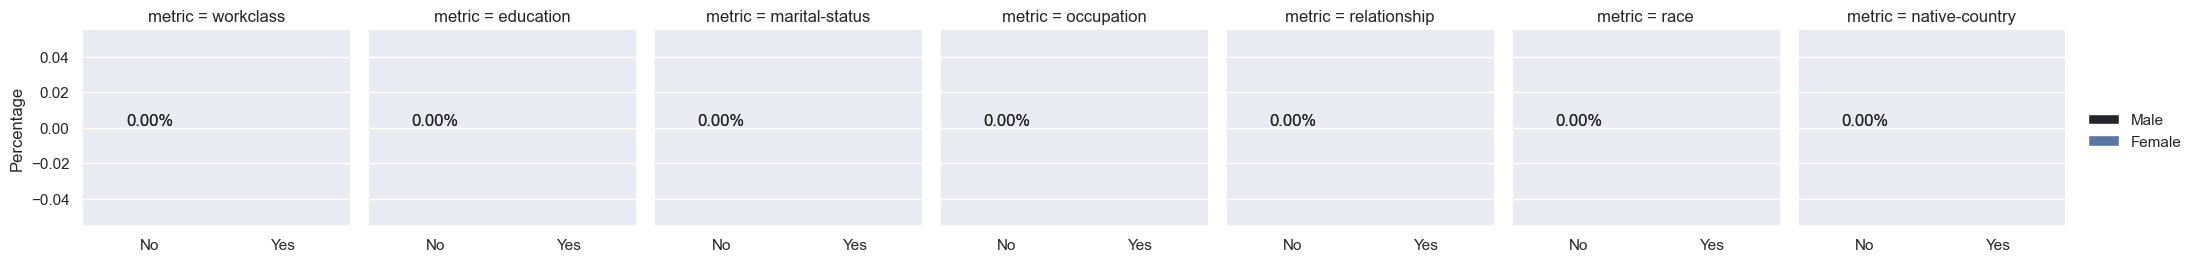

In [23]:
plot_countplot(X_cat_melt)